In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning import *

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Setup
---

## Load data


In [2]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

* ## Training data

In [3]:

prices_train = prices.loc['2024-01-01 00:00:00':'2024-01-31 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


* ## Test data 

In [4]:

prices_test = prices.loc['2024-02-01 00:00:00':'2024-02-29 23:55:00'] #February test data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [5]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-02-03 08:45:00,0.4414,0.4398
2024-02-03 08:50:00,0.4408,0.4392
2024-02-03 08:55:00,0.4403,0.4388
2024-02-03 09:00:00,0.4415,0.4401
2024-02-03 09:05:00,0.4415,0.4403
...,...,...
2024-02-29 23:35:00,0.6548,0.6037
2024-02-29 23:40:00,0.6633,0.6094
2024-02-29 23:45:00,0.6662,0.6150


# Train agent
---

In [4]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(0.5, 2.5), (1.0, 3.0), (1.5, 4.0), (2.0, 4.5), (2.5, 5.0), (3.0, 5.5)]
# Training parameters
F, T = 200, 100 #Formation is the last 16 hours and trading is the next 8 hours
initial_capital = 10_000
tx_cost = 0

# online_net, replay_buffer,epoch_loss_history, reward_history = train_dqn(zscore_series_train, 
#                                                                    prices_train, 
#                                                                    beta_series_train,
#                                                                    initial_capital,
#                                                                    tx_cost,
#                                                                    entry_stop_pairs, 
#                                                                    F, 
#                                                                    T, 
#                                                                    num_epochs=1000,
#                                                                    batch_size=32,
#                                                                    gamma = 0.99,
#                                                                    lr = 0.001,
#                                                                    epsilon_start = 1,
#                                                                    epsilon_end = 0.01,
#                                                                    epsilon_decay = 0.995,
#                                                                    replay_capacity = 1000,
#                                                                    target_update_freq = 10,
#                                                                    hidden_dim = 64,                                           
#                                                                     )

# # Save the trained model
# torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...


# Training performance
---

In [7]:
from pandas import Timestamp

def test_func():

    lista = [22]

    return 10,lista

reward,listing = test_func()
listing

[22]

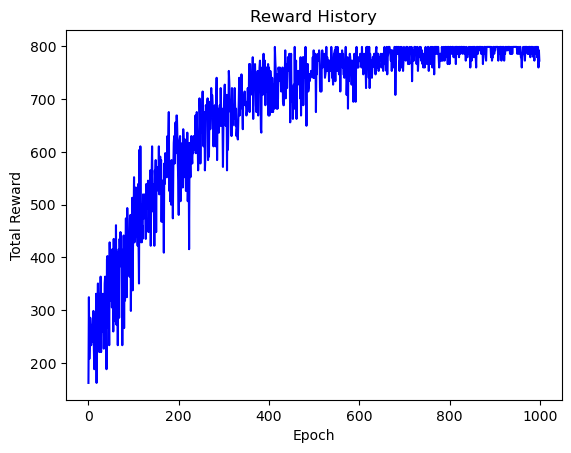

In [8]:
plt.plot(reward_history, color = 'blue')
plt.title('Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.show()

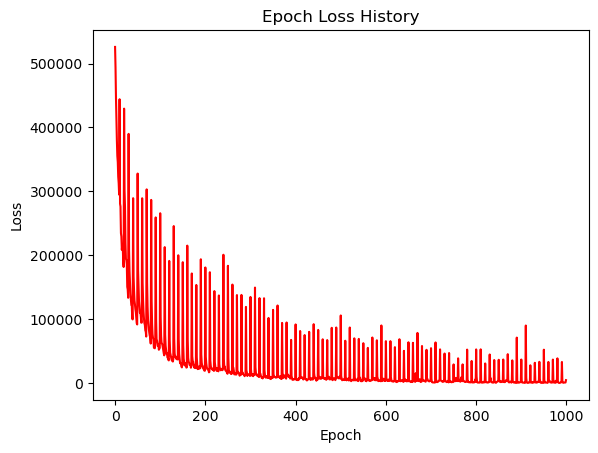

In [9]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Why the “sawtooth” spikes in the loss plot?

Those spikes are normal for two reasons:

    Variable number of updates per epoch: early on, you quickly fill the replay buffer and do many minibatch updates; later epochs may have fewer new transitions, so the average loss per epoch can jump around.

    Target-network syncs: whenever you copy the online net into the target net (every few epochs), you briefly raise the bootstrap targets, which can cause a transient bump in TD‐error before it falls again.

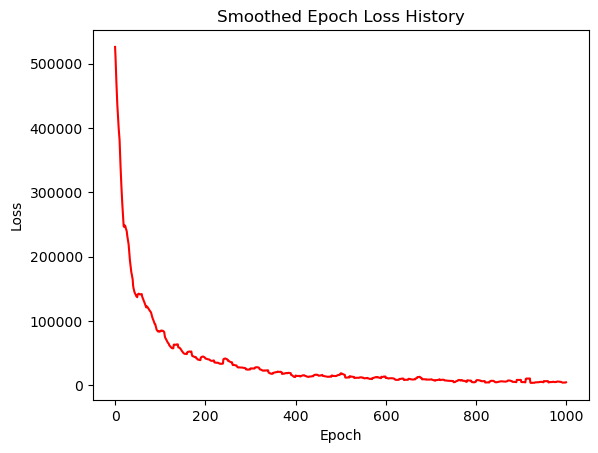

In [10]:
smoothed = pd.Series(epoch_loss_history).rolling(10, min_periods=1).mean()
plt.plot(smoothed, color = 'red')
plt.title('Smoothed Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test agent 
---

In [5]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=F, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_32257/3959656230.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net_trained.load_state_dict(torch.load

<All keys matched successfully>

In [6]:


# test_rewards,trade_profits,actions,metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_test,
#     prices_test,
#     beta_series_test,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
#     F, T
# )
# print(metrics)

tx_cost = 0.0

test_rewards,trade_profits,actions,episodes,metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_train,
    prices_train,
    beta_series_train,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
    F, T
)
print(metrics)

{'avg_reward': 798.7012987012987, 'win_rate': 0.8311688311688312, 'loss_rate': 0.0, 'forced_rate': 0.06493506493506493, 'no_trade_rate': 0.1038961038961039}


In [29]:
# zipper = zip(test_rewards, trade_profits, actions)
# counter = 0
# for reward, profit, action in zipper:
#     counter += 1
#     print(f"Reward: {reward}, Trade Profit: {profit}, Action: {action}")

# print("COUNTER:", counter)

In [9]:
#Get trade profits greater than 0
trade_profits = [trade_profit for trade_profit in trade_profits if trade_profit != 0]

In [10]:
len(trade_profits)

69

Episode {'trade_start': Timestamp('2024-01-18 16:45:00'), 'trade_end': Timestamp('2024-01-19 01:15:00'), 'trade_entry_metadata': None, 'entry': 2.5, 'stop': 5.0}:


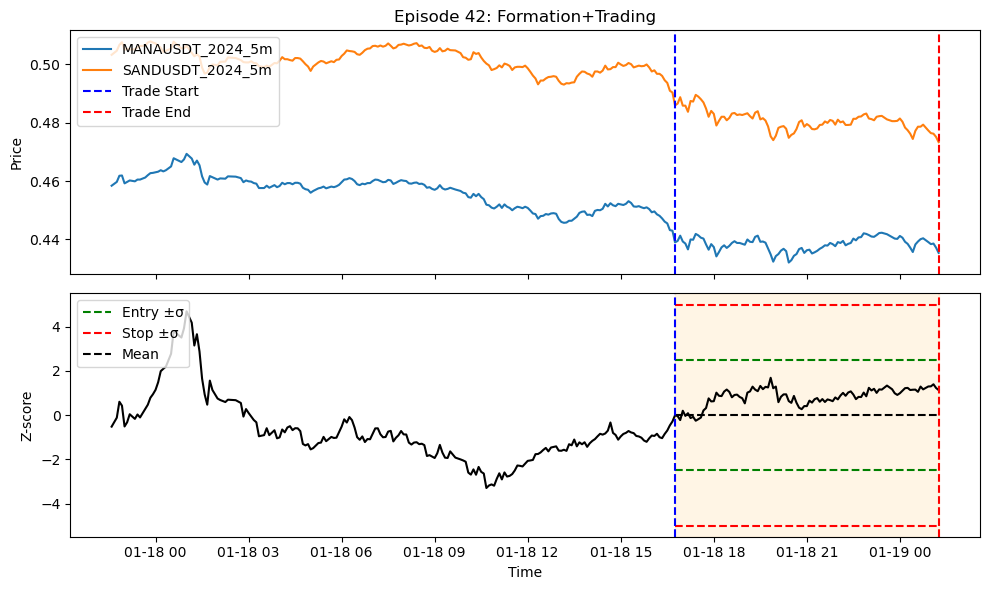

In [11]:
plot_episodes(prices_train, zscore_series_train, episodes, F, T, episode_idx=42)


In [10]:
test_rewards[42]

0.0

In [38]:
zscore_series_train

timestamp
2024-01-03 00:50:00   -0.050043
2024-01-03 00:55:00   -0.001561
2024-01-03 01:00:00   -0.028168
2024-01-03 01:05:00    0.017658
2024-01-03 01:10:00   -0.169765
                         ...   
2024-01-31 23:25:00    0.816195
2024-01-31 23:35:00    0.849163
2024-01-31 23:40:00    0.605611
2024-01-31 23:50:00    0.577522
2024-01-31 23:55:00    1.040269
Length: 7999, dtype: float64

Percentage_Return:  13.561605213849843 %


Text(0, 0.5, 'Cumulative Profit')

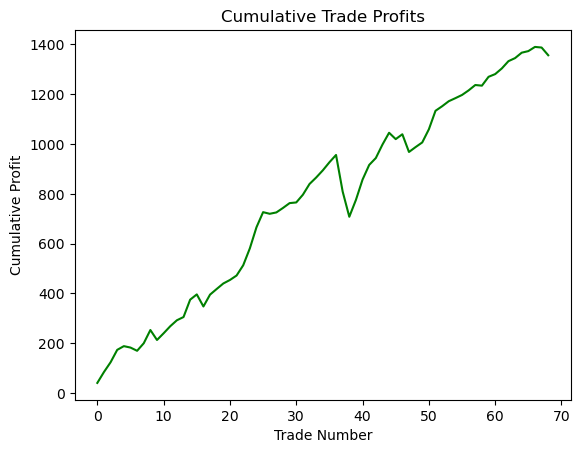

In [11]:
trade_profits_cumulative = np.cumsum(trade_profits)
plt.plot(trade_profits_cumulative, color = 'green')
print("Percentage_Return: ", (trade_profits_cumulative[-1] / initial_capital) * 100,"%")
plt.title('Cumulative Trade Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')


In [15]:
# entry_threshold = 1.5
# exit_threshold = 0
# stop_loss_threshold = 3

# positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
# trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

entry_threshold = 1.5
exit_threshold = 0
stop_loss_threshold = 4

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

In [13]:
len(trade_profits_no_agent)

69

Percentage_Return:  0.1154634793068848 %


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_31911/3214939763.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


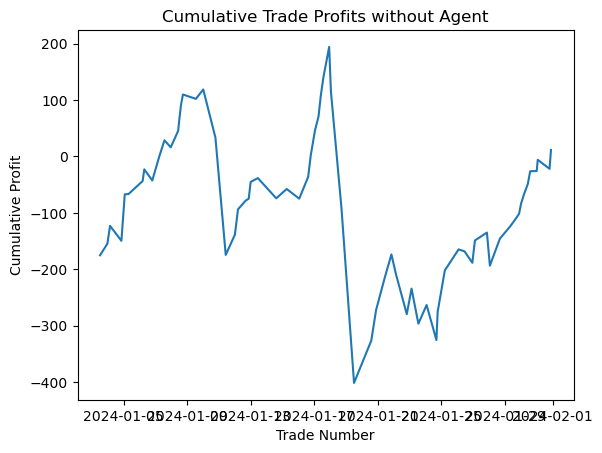

In [16]:
plt.plot(cumulative_profit_series_no_agent)
print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
plt.title('Cumulative Trade Profits without Agent')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()